In [45]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.base import clone
from xgboost import XGBClassifier

### Data Preparation

In [ ]:
X, y = fetch_openml('mnist_784', return_X_y=True)
print(X.shape, y.shape)

(70000, 784) (70000,)


In [ ]:
X = X.to_numpy(dtype=np.float32) if hasattr(X, 'to_numpy') else np.asarray(X, dtype=np.float32)
y = y.astype(np.int64) if hasattr(y, 'astype') else np.asarray(y, dtype=np.int64)
if X.ndim > 2:
    X = X.reshape(X.shape[0], -1)
X /= 255.0
print('X:', X.shape, X.dtype, '| y:', y.shape, y.dtype)

X: (70000, 784) float32 | y: (70000,) int64


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=10000, random_state=42, stratify=y
)
scaler = StandardScaler(with_mean=True, with_std=True)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
print('Train:', X_train.shape, X_train.dtype, 'Test:', X_test.shape, X_test.dtype)

Train: (60000, 784) float32 Test: (10000, 784) float32


In [ ]:
def label_dist(y):
    vals, cnts = np.unique(y, return_counts=True)
    pct = (cnts / cnts.sum()) * 100
    return {str(v): round(p, 2) for v, p in zip(vals, pct)}

print('Train size:', X_train.shape, '| Test size:', X_test.shape)
print('Class distribution (train %):', label_dist(y_train))
print('Class distribution (test %):', label_dist(y_test))

Train size: (60000, 784) | Test size: (10000, 784)
Class distribution (train %): {'0': np.float64(9.86), '1': np.float64(11.25), '2': np.float64(9.98), '3': np.float64(10.2), '4': np.float64(9.75), '5': np.float64(9.02), '6': np.float64(9.82), '7': np.float64(10.42), '8': np.float64(9.75), '9': np.float64(9.94)}
Class distribution (test %): {'0': np.float64(9.86), '1': np.float64(11.25), '2': np.float64(9.99), '3': np.float64(10.2), '4': np.float64(9.75), '5': np.float64(9.02), '6': np.float64(9.82), '7': np.float64(10.42), '8': np.float64(9.75), '9': np.float64(9.94)}


### Model Training

In [ ]:
results = []

models = [
    ("Logistic Regression", LogisticRegression(
        solver="saga", multi_class="multinomial", max_iter=1000, n_jobs=-1, verbose=0, random_state=42
    )),
    ("Linear SVM", LinearSVC(
        C=1.0, dual=True, max_iter=5000
    )),
    ("Decision Tree", DecisionTreeClassifier(
        criterion="gini", max_depth=None, random_state=42
    )),
    ("Random Forest", RandomForestClassifier(
        n_estimators=150, max_depth=None, n_jobs=-1, random_state=42
    )),
    ("XGBoost", XGBClassifier(
        objective="multi:softmax",
        num_class=10,
        n_estimators=200,
        max_depth=8,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        tree_method="hist",
        n_jobs=-1,
        random_state=42,
        verbosity=0
    )),
]

print("Training models...\n")
for name, model in models:
    start = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results.append({"model": name, "accuracy": acc, "train_time_sec": train_time})
    print(f"{name:>18} | acc: {acc:.4f} | time: {train_time:6.2f}s")

best = max(results, key=lambda r: r["accuracy"])  # highest accuracy
best_model = dict(models)[best["model"]]
print(f"\nBest model: {best['model']} (acc={best['accuracy']:.4f})")
print("Classification report (best model):")
print(classification_report(y_test, best_model.predict(X_test)))

summary_df = pd.DataFrame(results).sort_values("accuracy", ascending=False)
summary_df

Training models...



c:\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1264: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic Regression | acc: 0.9204 | time: 466.73s


c:\Python313\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


        Linear SVM | acc: 0.9126 | time: 1640.72s
     Decision Tree | acc: 0.8790 | time:  13.31s
     Random Forest | acc: 0.9685 | time:   9.75s
           XGBoost | acc: 0.9756 | time: 380.91s

Best model: XGBoost (acc=0.9756)
Classification report (best model):
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       986
           1       0.99      0.99      0.99      1125
           2       0.98      0.97      0.98       999
           3       0.97      0.97      0.97      1020
           4       0.98      0.97      0.98       975
           5       0.99      0.97      0.98       902
           6       0.98      0.99      0.98       982
           7       0.98      0.98      0.98      1042
           8       0.97      0.97      0.97       975
           9       0.95      0.95      0.95       994

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      

,model,accuracy,train_time_sec
4,XGBoost,0.9756,380.914728
3,Random Forest,0.9685,9.746084
0,Logistic Regression,0.9204,466.734674
1,Linear SVM,0.9126,1640.722143
2,Decision Tree,0.8790,13.310771


### Model Evaluation

In [ ]:
for name, model in models:
    print("=" * 80)
    print(f"Model: {name}")
    print("-" * 80)
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, digits=4, zero_division=0)
    print(report)
    print()

Model: Logistic Regression
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.9523    0.9726    0.9624       986
           1     0.9295    0.9724    0.9505      1125
           2     0.9329    0.8909    0.9114       999
           3     0.8965    0.8833    0.8899      1020
           4     0.9252    0.9262    0.9257       975
           5     0.8849    0.8780    0.8815       902
           6     0.9479    0.9633    0.9556       982
           7     0.9333    0.9395    0.9364      1042
           8     0.8989    0.8667    0.8825       975
           9     0.8959    0.9004    0.8981       994

    accuracy                         0.9204     10000
   macro avg     0.9197    0.9193    0.9194     10000
weighted avg     0.9202    0.9204    0.9201     10000


Model: Linear SVM
--------------------------------------------------------------------------------
              precision    recall

In [ ]:
rows = []
for name, model in models:
    y_pred = model.predict(X_test)
    rows.append({
        "model": name,
        "accuracy": accuracy_score(y_test, y_pred),
        "precision_weighted": precision_score(y_test, y_pred, average="weighted", zero_division=0),
        "recall_weighted": recall_score(y_test, y_pred, average="weighted", zero_division=0),
        "f1_weighted": f1_score(y_test, y_pred, average="weighted", zero_division=0),
        "precision_macro": precision_score(y_test, y_pred, average="macro", zero_division=0),
        "recall_macro": recall_score(y_test, y_pred, average="macro", zero_division=0),
        "f1_macro": f1_score(y_test, y_pred, average="macro", zero_division=0),
    })

metrics_df = pd.DataFrame(rows)

try:
    times_df = pd.DataFrame(results)[["model", "train_time_sec"]]
    metrics_df = metrics_df.merge(times_df, on="model", how="left")
except Exception:
    pass

metrics_df = metrics_df.sort_values(["accuracy", "f1_weighted"], ascending=[False, False]).reset_index(drop=True)
metrics_df

,model,accuracy,precision_weighted,recall_weighted,f1_weighted,precision_macro,recall_macro,f1_macro,train_time_sec
0,XGBoost,0.9756,0.975621,0.9756,0.975591,0.975541,0.975395,0.975447,380.914728
1,Random Forest,0.9685,0.968494,0.9685,0.968483,0.968292,0.968194,0.968229,9.746084
2,Logistic Regression,0.9204,0.920165,0.9204,0.920126,0.919737,0.919344,0.919389,466.734674
3,Linear SVM,0.9126,0.912142,0.9126,0.912204,0.911489,0.911428,0.911294,1640.722143
4,Decision Tree,0.8790,0.878788,0.8790,0.878820,0.877364,0.876980,0.877095,13.310771


### Error Analysis

In [ ]:
MAX_PER_MODEL = 10
miscls_by_model = {}
records = []

y_true_all = np.asarray(y_test)
for name, model in models:
    y_pred_all = np.asarray(model.predict(X_test))
    wrong = np.flatnonzero(y_pred_all != y_true_all)[:MAX_PER_MODEL]
    miscls_by_model[name] = {
        'indices': wrong,
        'y_true': y_true_all[wrong],
        'y_pred': y_pred_all[wrong],
    }
    for idx, t, p in zip(wrong, y_true_all[wrong], y_pred_all[wrong]):
        records.append({'model': name, 'index': int(idx), 'true': int(t), 'pred': int(p)})

miscls_df2 = pd.DataFrame(records)
miscls_df2.head(20)

,model,index,true,pred
0,Logistic Regression,31,5,8
1,Logistic Regression,84,9,7
2,Logistic Regression,92,0,3
3,Logistic Regression,194,3,5
4,Logistic Regression,207,2,9
5,Logistic Regression,226,8,3
6,Logistic Regression,228,7,1
7,Logistic Regression,258,3,8
8,Logistic Regression,259,9,4
9,Logistic Regression,279,9,5


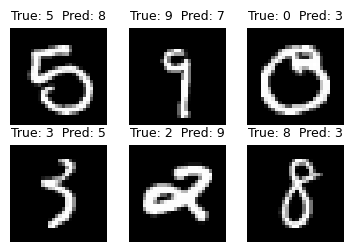

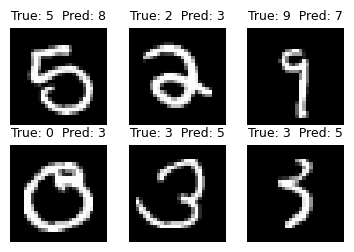

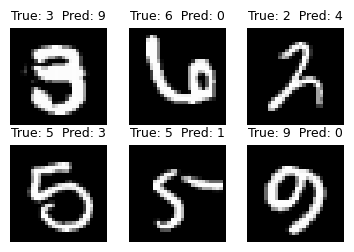

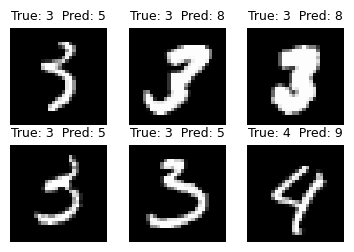

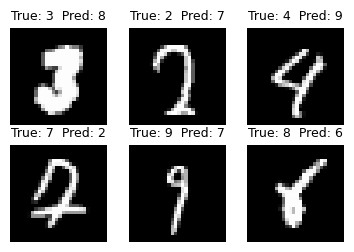

In [ ]:
SAMPLES_PER_MODEL = 6

def to_img_clean(x):
    try:
        v = scaler.inverse_transform(x.reshape(1, -1)).ravel()
        v = np.clip(v, 0.0, 1.0)
    except Exception:
        v = np.asarray(x, dtype=np.float32)
        v = v - v.min()
        v = v / (v.max() + 1e-8)
    return v.reshape(28, 28)

for name, payload in miscls_by_model.items():
    idxs = payload['indices'][:SAMPLES_PER_MODEL]
    if len(idxs) == 0:
        continue
    t = payload['y_true'][:len(idxs)]
    p = payload['y_pred'][:len(idxs)]

    n = len(idxs)
    cols = 3
    rows = int(np.ceil(n / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 1.2, rows * 1.2), dpi=100)
    axes = np.array(axes).reshape(-1)

    for ax in axes[n:]:
        ax.axis('off')

    for i, (idx, true, pred) in enumerate(zip(idxs, t, p)):
        ax = axes[i]
        ax.imshow(to_img_clean(X_test[idx]), cmap='gray', vmin=0.0, vmax=1.0, interpolation='nearest')
        ax.axis('off')
        ax.set_title(f"True: {int(true)}  Pred: {int(pred)}", fontsize=9)

    plt.tight_layout(pad=0.3)
    plt.show()

### Output & Visualization

                 model  accuracy
0              XGBoost    0.9756
1        Random Forest    0.9685
2  Logistic Regression    0.9204
3           Linear SVM    0.9126
4        Decision Tree    0.8790


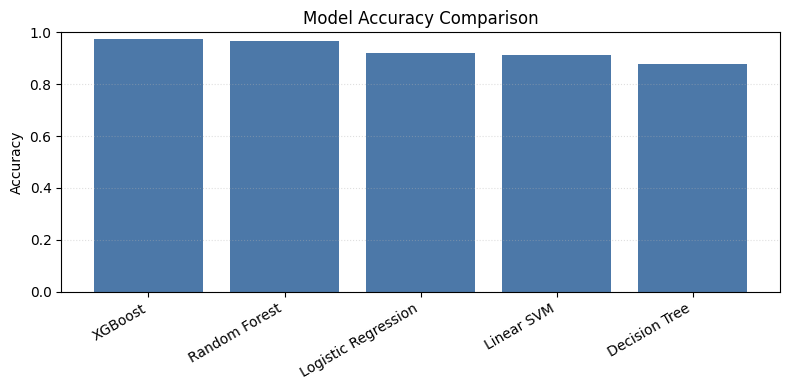

In [ ]:
try:
    acc_df = metrics_df[["model", "accuracy"]].copy()
except Exception:
    rows = []
    for name, model in models:
        y_pred = model.predict(X_test)
        rows.append({"model": name, "accuracy": accuracy_score(y_test, y_pred)})
    acc_df = pd.DataFrame(rows)

acc_df = acc_df.sort_values("accuracy", ascending=False).reset_index(drop=True)
print(acc_df)

plt.figure(figsize=(8, 4))
plt.bar(acc_df["model"], acc_df["accuracy"], color="#4C78A8")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.title("Model Accuracy Comparison")
plt.xticks(rotation=30, ha="right")
plt.grid(axis="y", linestyle=":", alpha=0.4)
plt.tight_layout()
plt.show()

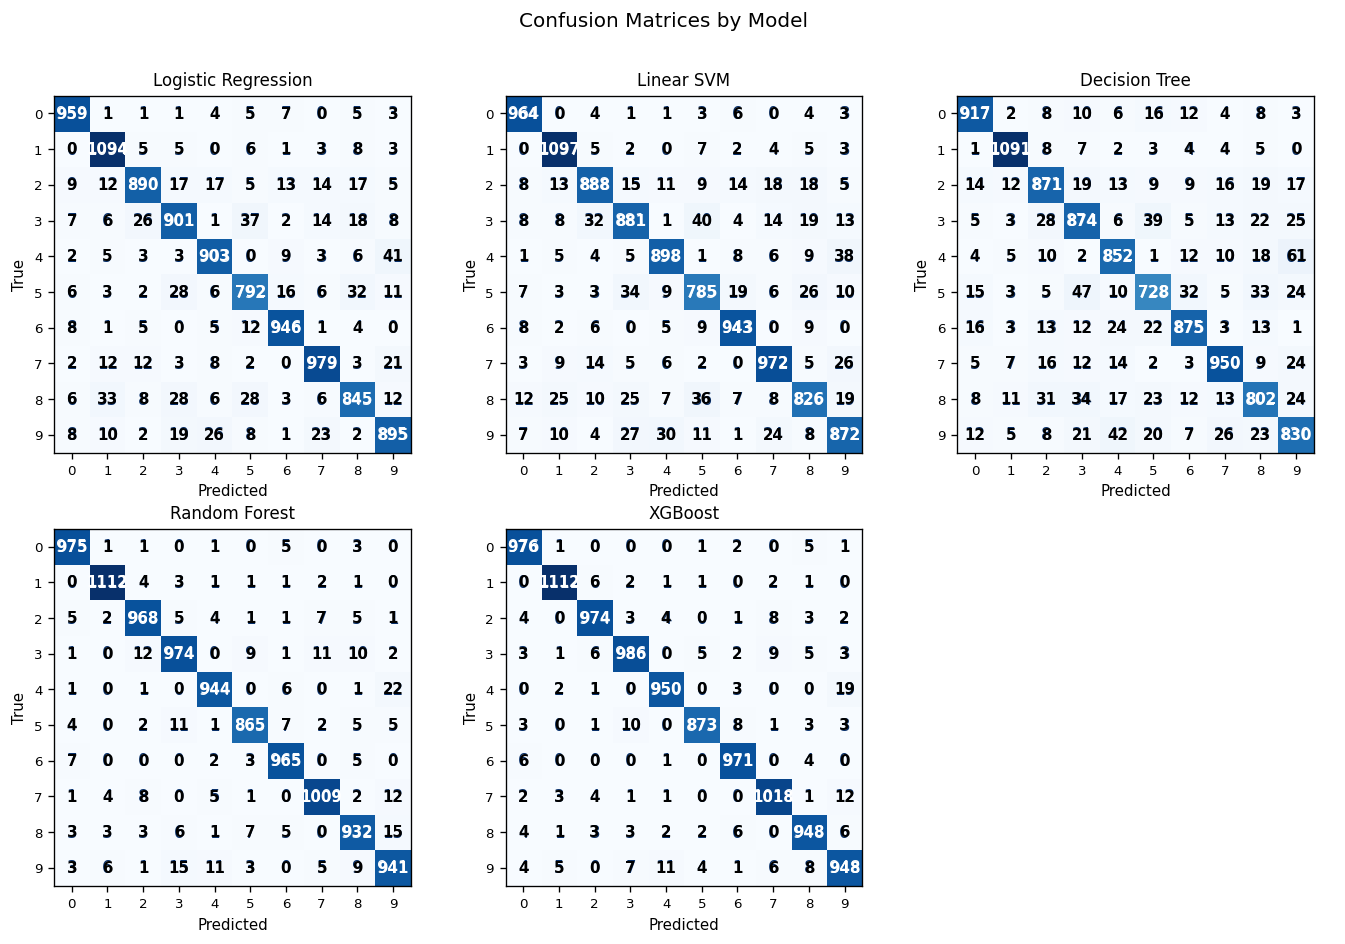

In [32]:
labels = np.unique(y_test)

n_models = len(models)
cols = 3
rows = int(np.ceil(n_models / cols))
fig, axes = plt.subplots(rows, cols, figsize=(cols * 3.8, rows * 3.8), dpi=120)
axes = np.array(axes).reshape(rows, cols)

for idx, (name, model) in enumerate(models):
    r, c = divmod(idx, cols)
    ax = axes[r, c]
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(ax=ax, colorbar=False, cmap="Blues")
    cm_max = cm.max()
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            v = cm[i, j]
            color = "white" if v > cm_max * 0.5 else "black"
            ax.text(j, i, str(v), ha="center", va="center", color=color, fontsize=9, fontweight="bold")
    ax.set_title(name, fontsize=10)
    ax.set_xlabel("Predicted", fontsize=9)
    ax.set_ylabel("True", fontsize=9)
    ax.tick_params(axis='both', labelsize=8)

for j in range(n_models, rows * cols):
    r, c = divmod(j, cols)
    axes[r, c].axis("off")

fig.suptitle("Confusion Matrices by Model", fontsize=12, y=1.02)
plt.tight_layout(pad=0.8)
plt.show()

### training time comparison

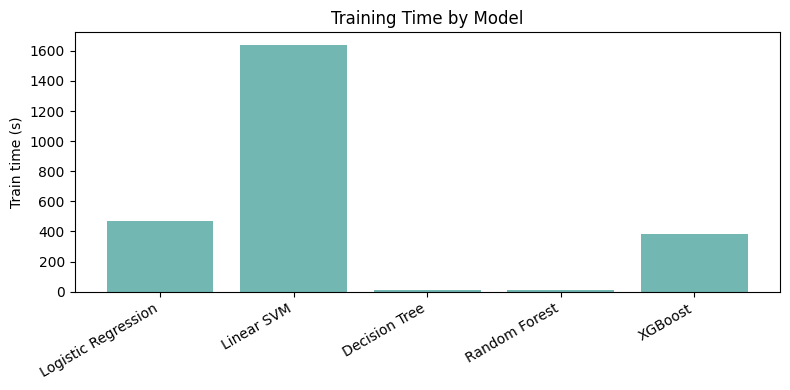

                 model  accuracy  train_time_sec
4              XGBoost    0.9756      380.914728
3        Random Forest    0.9685        9.746084
0  Logistic Regression    0.9204      466.734674
1           Linear SVM    0.9126     1640.722143
2        Decision Tree    0.8790       13.310771


In [ ]:
try:
    times_df = pd.DataFrame(results)[["model", "train_time_sec"]].copy()
except Exception:
    times_df = None

if times_df is None or times_df["train_time_sec"].isna().all():
    rows = []
    for name, model in models:
        m = clone(model)
        start = time.time()
        m.fit(X_train, y_train)
        train_time = time.time() - start
        rows.append({"model": name, "train_time_sec": train_time})
    times_df = pd.DataFrame(rows)

plt.figure(figsize=(8, 4))
plt.bar(times_df["model"], times_df["train_time_sec"], color="#72B7B2")
plt.ylabel("Train time (s)")
plt.title("Training Time by Model")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

try:
    pred_df = pd.DataFrame(results)[["model", "accuracy"]]
except Exception:
    pred_df = acc_df[["model", "accuracy"]]

pred_df = pred_df.merge(times_df[["model", "train_time_sec"]], on="model", how="left")
print(pred_df.sort_values("accuracy", ascending=False))

In [ ]:
subset_size = 4000
rng = np.random.RandomState(42)
idx = rng.choice(X_train.shape[0], size=min(subset_size, X_train.shape[0]), replace=False)
X_cv = X_train[idx]
y_cv = np.asarray(y_train)[idx]

cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
rows = []
for name, model in models:
    if isinstance(model, XGBClassifier):
        params = model.get_params()
        m = XGBClassifier(
            objective="multi:softmax", num_class=10,
            n_estimators=min(80, params.get('n_estimators', 200)),
            max_depth=params.get('max_depth', 8),
            learning_rate=params.get('learning_rate', 0.2),
            subsample=params.get('subsample', 0.8),
            colsample_bytree=params.get('colsample_bytree', 0.8),
            tree_method=params.get('tree_method', 'hist'),
            n_jobs=1, random_state=42, verbosity=0
        )
    elif isinstance(model, LogisticRegression):
        params = model.get_params()
        m = LogisticRegression(
            solver=params.get('solver', 'saga'), multi_class=params.get('multi_class', 'multinomial'),
            max_iter=min(300, params.get('max_iter', 1000)), n_jobs=1, verbose=0, random_state=42
        )
    elif isinstance(model, LinearSVC):
        params = model.get_params()
        m = LinearSVC(C=params.get('C', 1.0), dual=params.get('dual', True), max_iter=min(1500, params.get('max_iter', 5000)))
    elif isinstance(model, RandomForestClassifier):
        params = model.get_params()
        m = RandomForestClassifier(
            n_estimators=min(80, params.get('n_estimators', 150)),
            max_depth=params.get('max_depth', None),
            n_jobs=1, random_state=42
        )
    elif isinstance(model, DecisionTreeClassifier):
        params = model.get_params()
        m = DecisionTreeClassifier(criterion=params.get('criterion', 'gini'), max_depth=params.get('max_depth', None), random_state=42)
    else:
        m = model
    scores = cross_val_score(m, X_cv, y_cv, cv=cv, scoring='accuracy', n_jobs=1)
    rows.append({'model': name, 'acc_mean': scores.mean(), 'acc_std': scores.std()})

cv_df = pd.DataFrame(rows).sort_values('acc_mean', ascending=False)
print(cv_df)

c:\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1264: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1264: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1264: FutureWarning: 'multi_class' was deprecated i

                 model  acc_mean  acc_std
3        Random Forest   0.92125  0.00025
4              XGBoost   0.90950  0.00650
0  Logistic Regression   0.87725  0.00625
1           Linear SVM   0.80875  0.00975
2        Decision Tree   0.72850  0.00400
